In [1]:
import os
import pickle
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

plt.style.use('seaborn')

## Preparing Data
60% training, 20% validation, and 20% testing

In [ ]:
# TODO: Move these two functions to a shared file for helper functions
def unPickleData(filename):
    with open(filename,'rb') as f: arr = pickle.load(f)
    return arr


def getDataPath(dirname,filename):
    return os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)),"processed_data", dirname,filename)

print(getDataPath("comments","X_comments.pkl"))

X_data = unPickleData(getDataPath("comments","X_comments.pkl"))
y_data = unPickleData(getDataPath("comments","Y_comments.pkl"))

# reducing amount of features
X, y = [], []
Class0_max_count = 37000
for i in range(len(X_data)):
    if y_data[i] == 0: 
        if Class0_max_count > 0:
            # print(i)
            X.append(X_data[i])
            y.append(y_data[i])
            if i%1000 == 0: print(i, end=" ")
            Class0_max_count -= 1 
    else:
        X.append(X_data[i])
        y.append(y_data[i])


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.4, random_state=15, stratify=y)
X_val,   X_test, y_val,   y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state=15, stratify=y_temp)
number_features = len(X_train[0])

In [4]:
# Remove both lists to save up  memory
del X
del y

## Training

In [5]:
estimator = LogisticRegression()

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(estimator, 
                                                                    X_train, 
                                                                    y_train, 
                                                                    # scoring='accuracy', 
                                                                    cv=5, 
                                                                    return_times=True)                       

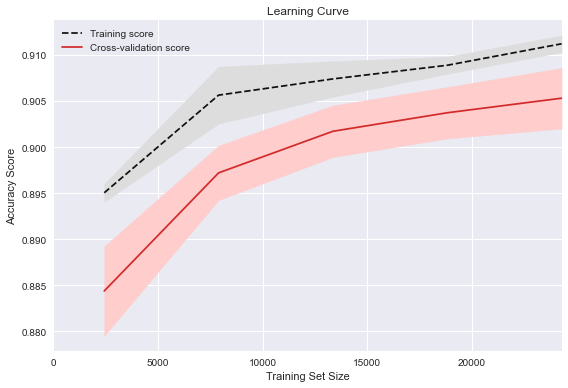

In [7]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#D22B2B", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#ffcdcc")

# plt.ylim([0, 1])
plt.xlim([0, train_sizes[-1]])
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Model Selection

In [10]:
estimator = LogisticRegression(solver="liblinear")
grid = {"C":np.logspace(-3,3,8), "penalty":["l1", "l2"]}

search = GridSearchCV(estimator,grid,cv=10)
search.fit(X_val,y_val)

print("Tuned hpyerparameters :(best parameters) ",search.best_params_)
print("Accuracy :",search.best_score_)

best_model = search.best_estimator_

Tuned hpyerparameters :(best parameters)  {'C': 2.6826957952797246, 'penalty': 'l2'}
Accuracy : 0.9011758013628739


## Testing

### Excluding the validation set

In [11]:
y_pred = best_model.predict(X_test)

print(sklearn.metrics.classification_report(y_test,y_pred))
print("Accuracy: ", sklearn.metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7501
           1       0.93      0.68      0.79      2618

    accuracy                           0.91     10119
   macro avg       0.92      0.83      0.86     10119
weighted avg       0.91      0.91      0.90     10119

Accuracy:  0.905128965312778


### Including the validation set
Because of the lack of representation of the class "bot", especially in the testing data, the model reflects poor results when it comes to the recall and f-score.

In [12]:
y_pred = best_model.predict(np.concatenate((X_test,X_val)))
print(sklearn.metrics.classification_report(np.concatenate((y_test,y_val)),y_pred))
print("Accuracy: ", sklearn.metrics.accuracy_score(np.concatenate((y_test,y_val)), y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     15001
           1       0.95      0.70      0.81      5237

    accuracy                           0.91     20238
   macro avg       0.93      0.84      0.88     20238
weighted avg       0.92      0.91      0.91     20238

Accuracy:  0.9131831208617452


In [13]:
with open("best_logreg_model.pkl", 'wb') as file:
    pickle.dump(best_model, file)